In [1]:
using AlgebraicStockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
#using Catlab.Theories
using Catlab.WiringDiagrams

In [2]:
display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

The figure shows the composition is list as follows:
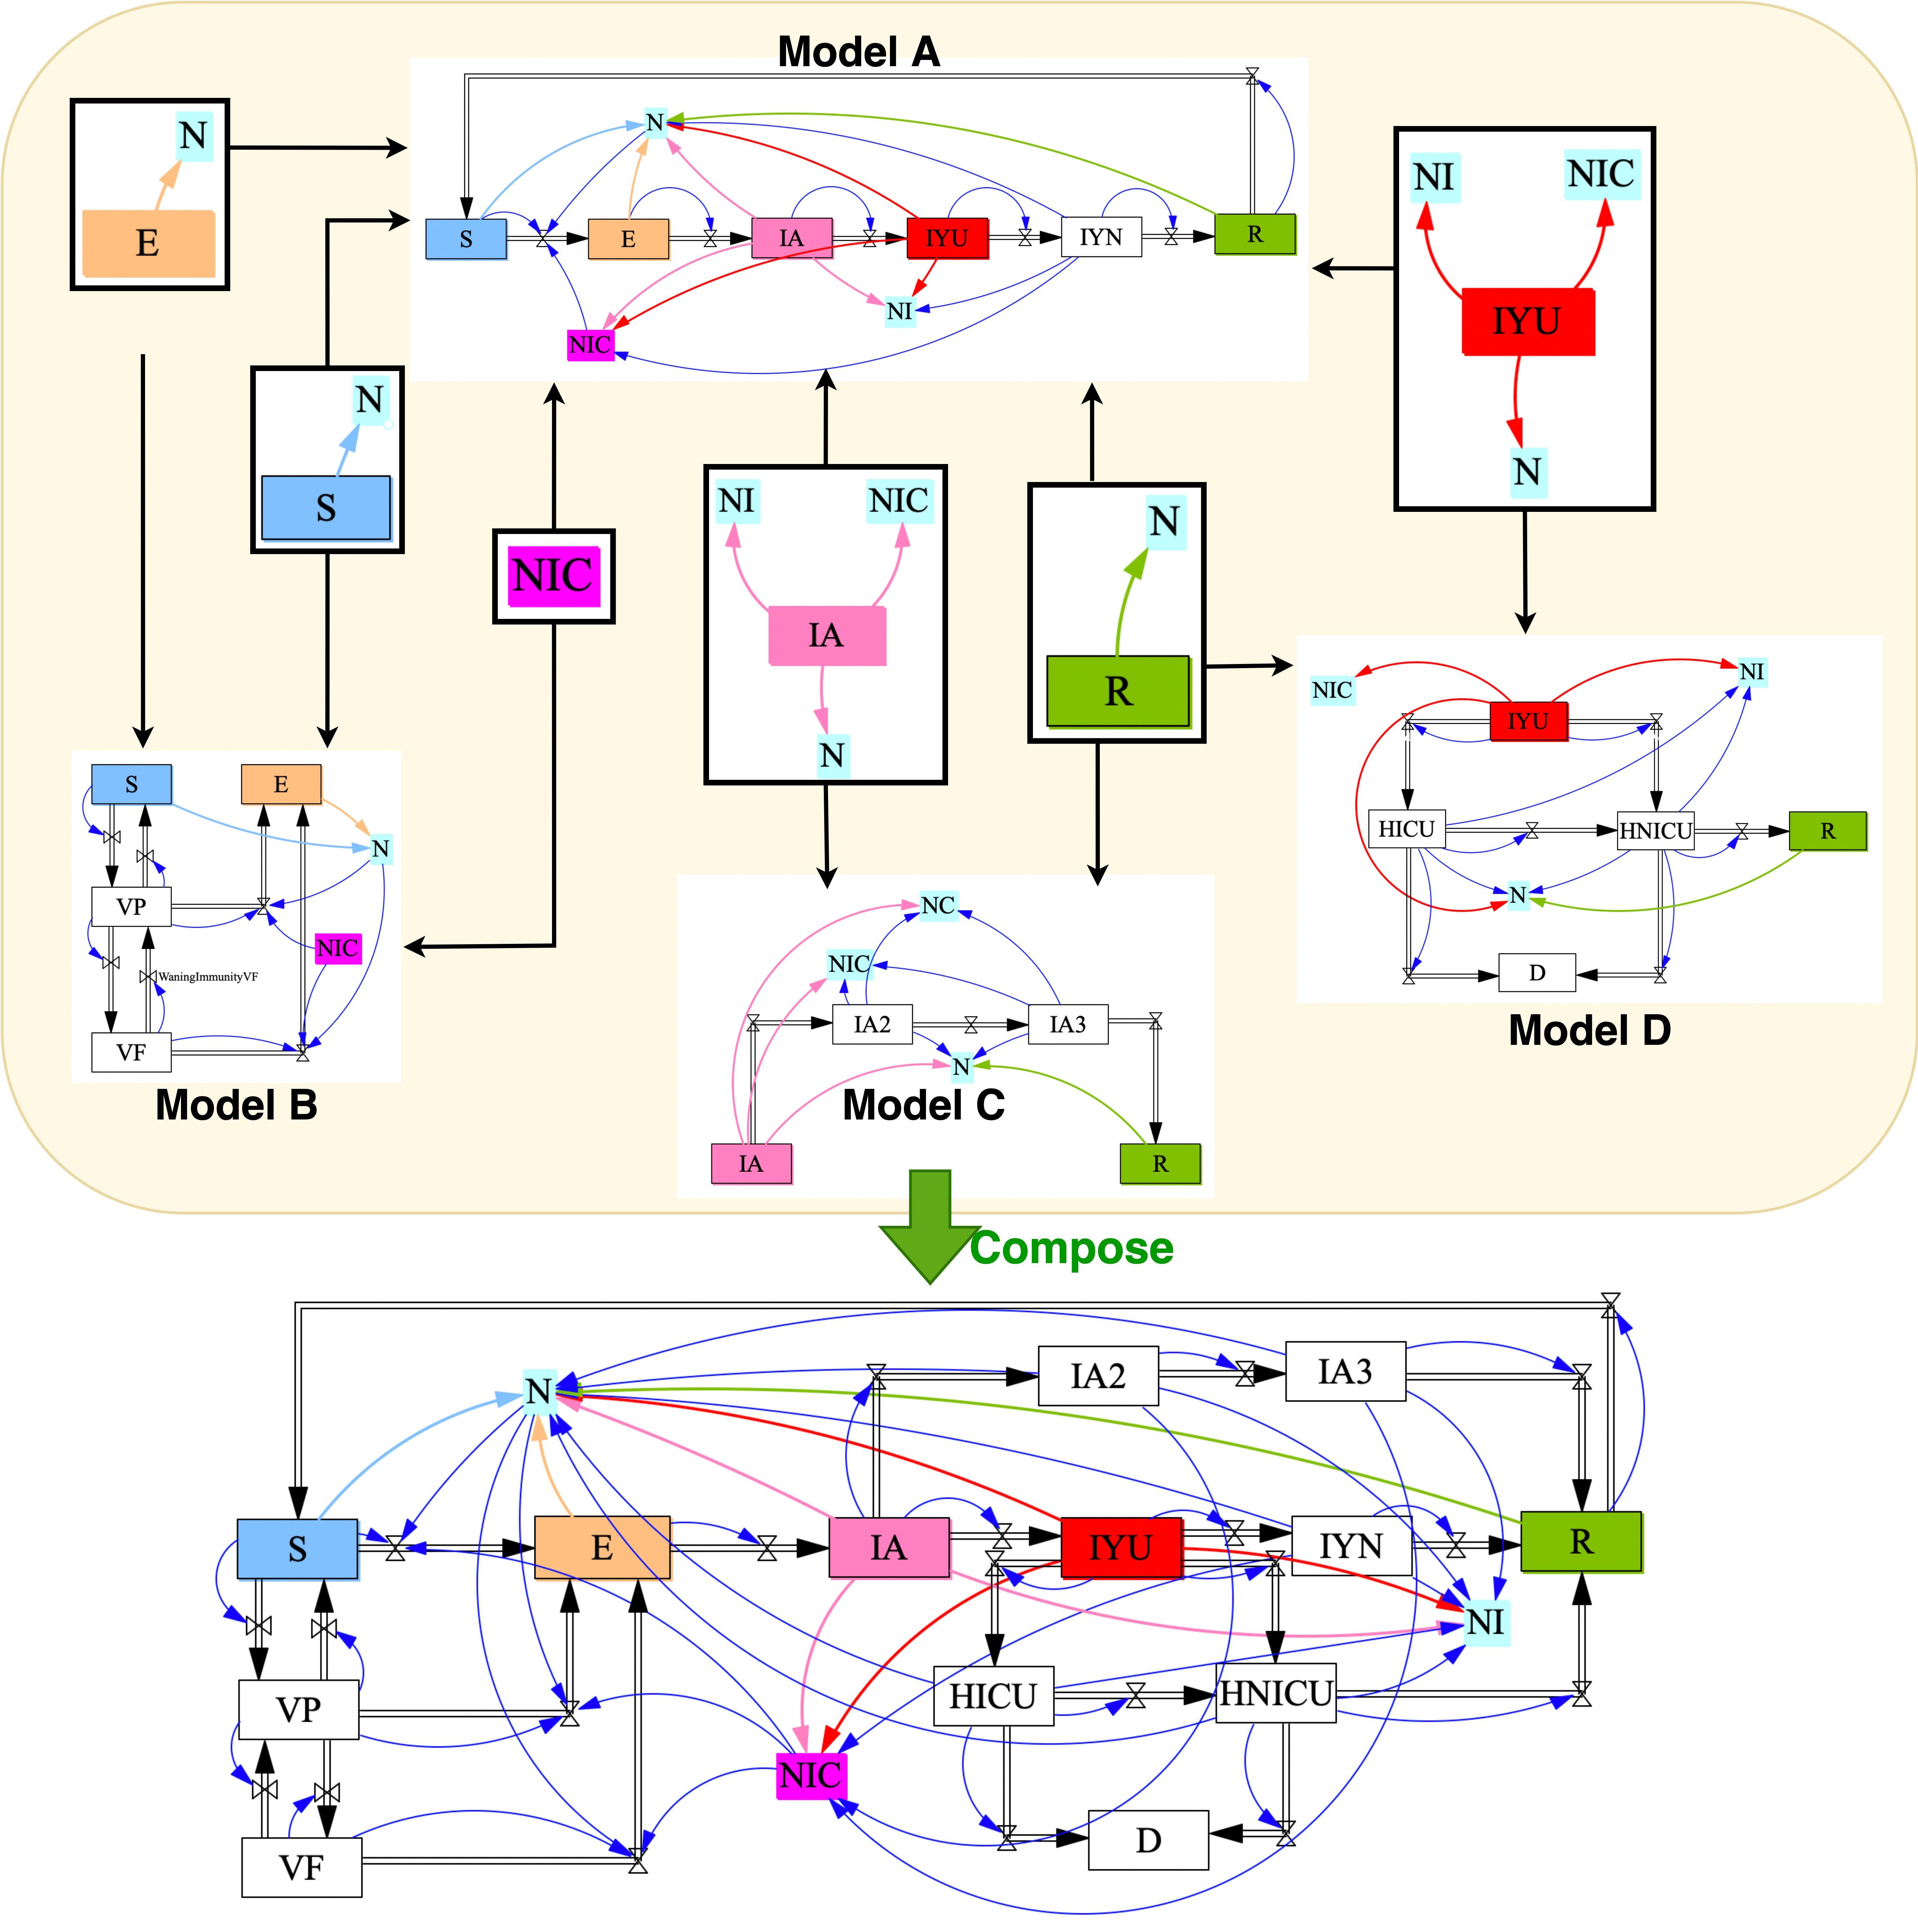

Math Equations of the composed COVID-19 model:
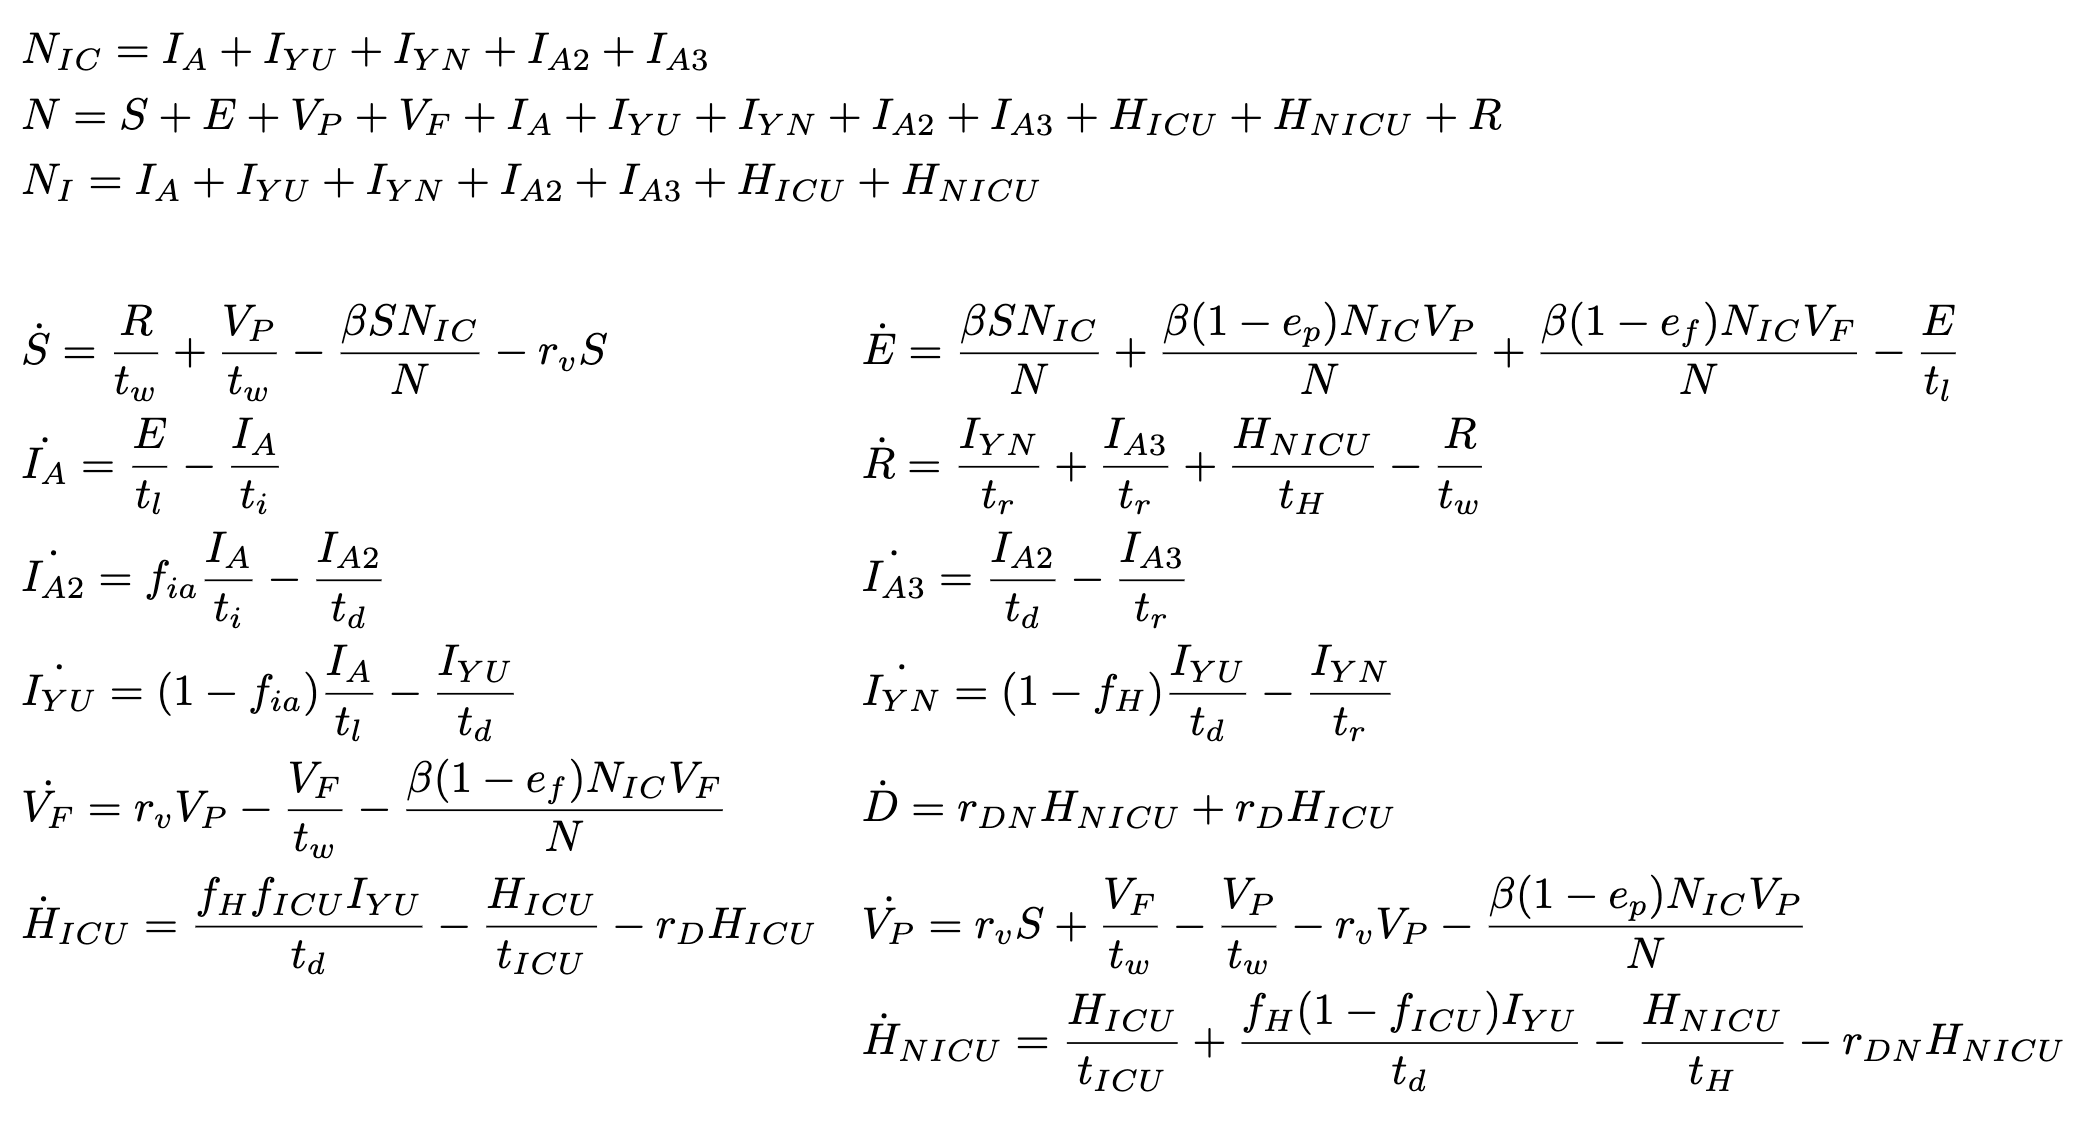

# Model A: 
Model A simulates the disease spread through the symptomatic infectious, development. This is an extended model based on SEIR model, where stock IA represent infectives during asymptomatic stage before symptomics occur; stock IYU represents symptomatic infectives with complications; stock IYN represents symptomatic infectives without complications.
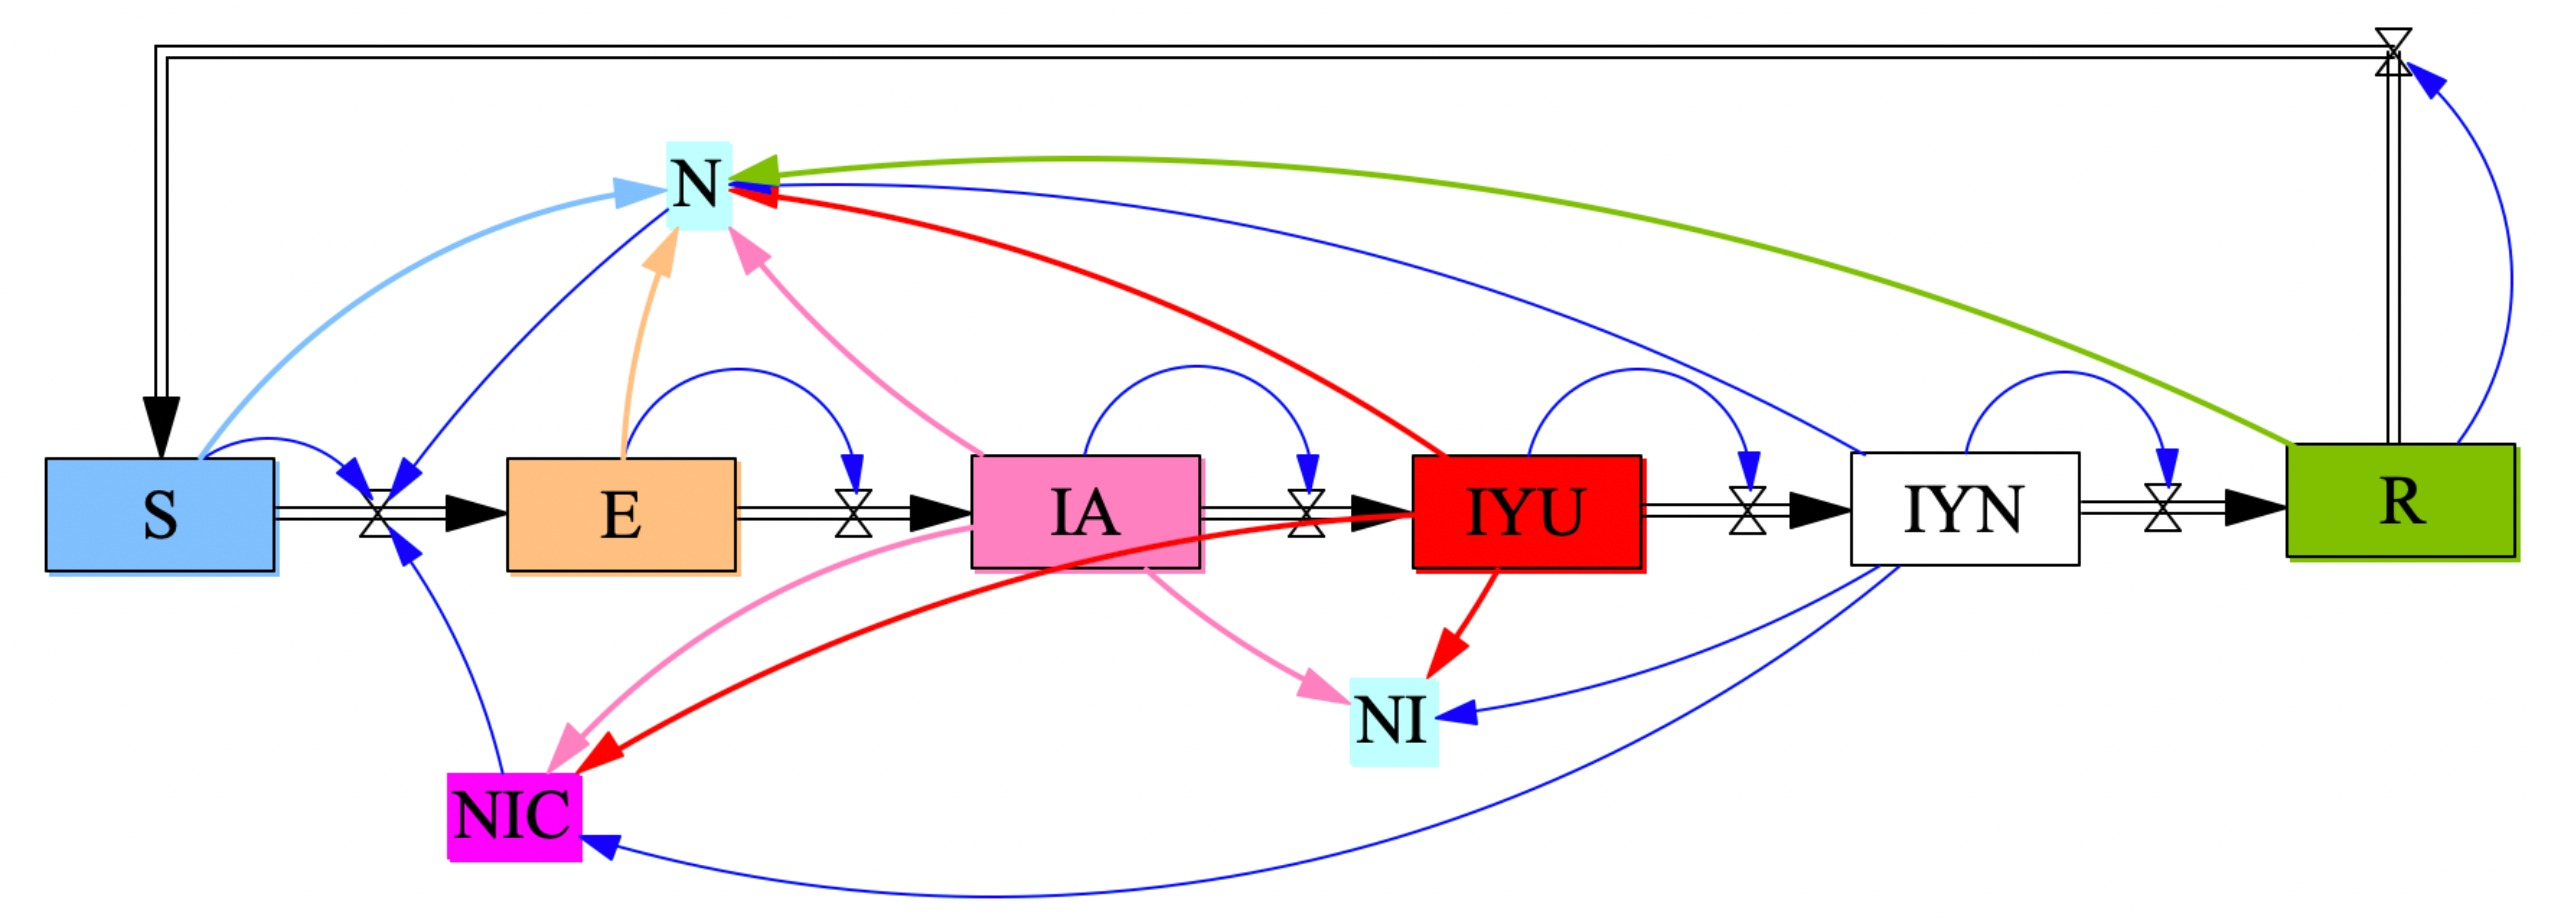

In [3]:
# define functions ϕ of flows in the SEIR model
fNewIncidence(u,uN,p,t)=p.β*u.S*uN.NIC(u,t)/uN.N(u,t)
fNewInfectious(u,uN,p,t)=u.E*p.rLatent
fBecomingSymptomatic(u,uN,p,t)=u.IA*p.rIncubation
fSymptomicsNotDevelopingComplications(u,uN,p,t)=u.IYU*p.rDevelop
fNewRecovery(u,uN,p,t)=u.IYN*p.rRecovery
fWaningImmunityR(u,uN,p,t)=u.R*p.rw

fWaningImmunityR (generic function with 1 method)

In [4]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
seir=StockAndFlow(
    (:S=>(:WaningImmunityR,:NewIncidence,:v_NewIncidence,:N),
        :E=>(:NewIncidence,:NewInfectious,:v_NewInfectious,:N),
        :IA=>(:NewInfectious,:BecomingSymptomatic,:v_BecomingSymptomatic,(:N,:NIC,:NI)),
        :IYU=>(:BecomingSymptomatic,:SymptomicsNotDevelopingComplications,:v_SymptomicsNotDevelopingComplications,(:N,:NIC,:NI)),
        :IYN=>(:SymptomicsNotDevelopingComplications,:NewRecovery,:v_NewRecovery,(:N,:NIC,:NI)),
        :R=>(:NewRecovery,:WaningImmunityR,:v_WaningImmunityR,:N)),
    (:NewIncidence=>:v_NewIncidence,:NewInfectious=>:v_NewInfectious,:BecomingSymptomatic=>:v_BecomingSymptomatic,:SymptomicsNotDevelopingComplications=>:v_SymptomicsNotDevelopingComplications,:NewRecovery=>:v_NewRecovery,:WaningImmunityR=>:v_WaningImmunityR),
    (:v_NewIncidence=>fNewIncidence,:v_NewInfectious=>fNewInfectious,:v_BecomingSymptomatic=>fBecomingSymptomatic,:v_SymptomicsNotDevelopingComplications=>fSymptomicsNotDevelopingComplications,:v_NewRecovery=>fNewRecovery,:v_WaningImmunityR=>fWaningImmunityR),
    (:N=>:v_NewIncidence,:NIC=>:v_NewIncidence, :NI=>:SVV_NONE)
)

StockAndFlow with elements S = 1:6, SV = 1:3, LS = 1:12, F = 1:6, I = 1:6, O = 1:6, V = 1:6, LV = 1:6, LSV = 1:2
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     E │
│ 3 │    IA │
│ 4 │   IYU │
│ 5 │   IYN │
│ 6 │     R │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │    NIC │
│  3 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   3 │    2 │
│  5 │   3 │    3 │
│  6 │   4 │    1 │
│  7 │   4 │    2 │
│  8 │   4 │    3 │
│  9 │   5 │    1 │
│ 10 │   5 │    2 │
│ 11 │   5 │    3 │
│ 12 │   6 │    1 │
└────┴─────┴──────┘
┌───┬────┬──────────────────────────────────────┐
│ F │ fv │                                fname │
├───┼────┼──────────────────────────────────────┤
│ 1 │  1 │                         NewIncidence │
│ 2 │  2 │                        NewInfectious │
│ 3 │  3 │                  BecomingSymptomatic │
│ 4 │  4 │ SymptomicsNotDevelopingComplications │
│ 5 │  5 │                          NewRecovery │
│ 6 │  6 │                      WaningImmunityR │
└───┴────┴──────────────────────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   6 │  1 │
│ 2 │   1 │  2 │
│ 3 │   2 │  3 │
│ 4 │   3 │  4 │
│ 5 │   4 │  5 │
│ 6 │   5 │  6 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  3 │
│ 4 │   4 │  4 │
│ 5 │   5 │  5 │
│ 6 │   6 │  6 │
└───┴─────┴────┘
┌───┬───────────────────────────────────────┬───────────────────────────────────
│ V │                             funcDynam │                                  ⋯
├───┼───────────────────────────────────────┼───────────────────────────────────
│ 1 │                         fNewIncidence │                         v_NewInc ⋯
│ 2 │                        fNewInfectious │                        v_NewInfe ⋯
│ 3 │                  fBecomingSymptomatic │                  v_BecomingSympt ⋯
│ 4 │ fSymptomicsNotDevelopingComplications │ v_SymptomicsNotDevelopingComplic ⋯
│ 5 │                          fNewRecovery │                          v_NewRe ⋯
│ 6 │                      fWaningImmunityR │                      v_WaningImm ⋯
└───┴───────────────────────────────────────┴───────────────────────────────────
                                                                1 column omitted
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   1 │
│  2 │   2 │   2 │
│  3 │   3 │   3 │
│  4 │   4 │   4 │
│  5 │   5 │   5 │
│  6 │   6 │   6 │
└────┴─────┴─────┘
┌─────┬───────┬──────┐
│ LSV │ lsvsv │ lsvv │
├─────┼───────┼──────┤
│   1 │     1 │    1 │
│   2 │     2 │    1 │
└─────┴───────┴──────┘

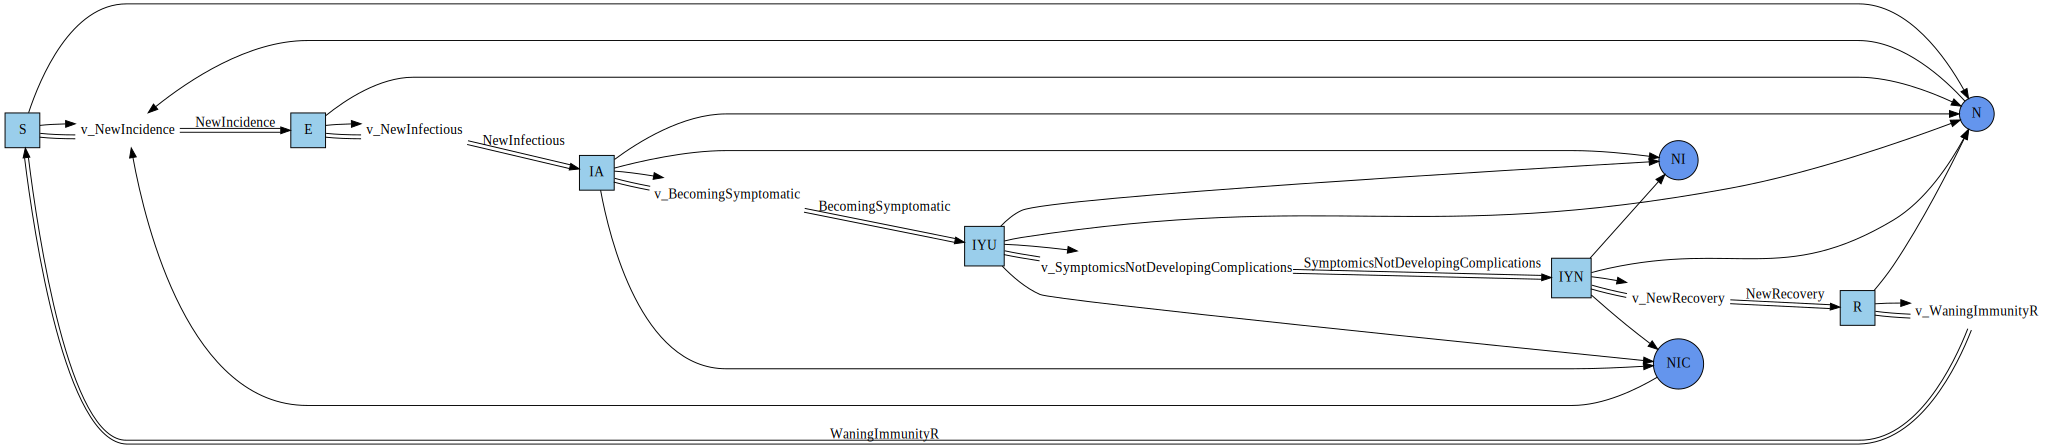

In [5]:
Graph(seir)

# Model B: 
Model B simulates the vaccination process. The stock “VP” represents individuals who are partially vaccinated, because they have only received the first dose of the vaccine or immunity from vaccination has decrease. In contrast, the stock “VF” represents individuals who are fully vaccinated having received two doses of the vaccine or immunity from vaccination has increase due to boosters. Notably, both partially and fully vaccinated individuals are not fully protected from transmitting the disease. Thus, there are flows from stock “VP” and “VF” to “E” that represents the new infection of vaccinated individuals.
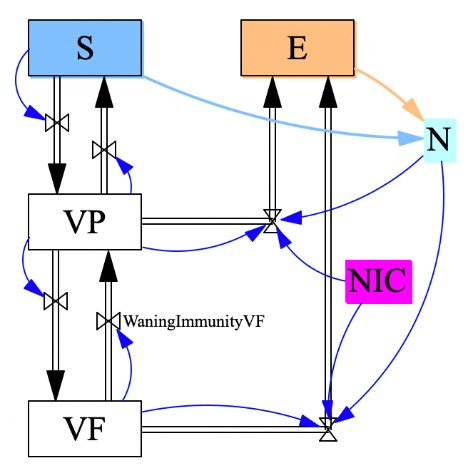

In [6]:
# define functions ϕ of flows in the Vaccine model
fFirstdoseVaccine(u,uN,p,t) = u.S * p.rv
fSeconddoseVaccine(u,uN,p,t) = u.VP * p.rv
fWaningImmunityVP(u,uN,p,t) = u.VP * p.rw
fWaningImmunityVF(u,uN,p,t) = u.VF * p.rw
fNewIncidenceVP(u,uN,p,t) = p.β*u.VP*(1.0-p.eP)*uN.NIC(u,t)/uN.N(u,t)
fNewIncidenceVF(u,uN,p,t) = p.β*u.VF*(1.0-p.eF)*uN.NIC(u,t)/uN.N(u,t)

fNewIncidenceVF (generic function with 1 method)

In [7]:
#(stock_name=>(inflows, outflows, variables, svariables))
     ## if a stock has no inflow or no outflow, use keyword ":F_NONE"
     ## if a stock has no variables connect to, use keyword ":V_NONE"
     ## if a stock has no sum_variables connect to, use keyword ":SV_NONE"
#(flow=>variable)
#(variable=>function)
#(svariable=>variable)
     ## if sum_variable contributes to no variables, use keywork ":SVV_NONE"
v=StockAndFlow(
    (:S=>(:WaningImmunityVP,:FirstdoseVaccine,:v_FirstdoseVaccine,:N),
        :E=>((:NewIncidenceVP,:NewIncidenceVF),:F_NONE,:V_NONE,:N),
        :VP=>((:FirstdoseVaccine,:WaningImmunityVF),(:SeconddoseVaccine, :WaningImmunityVP, :NewIncidenceVP),(:v_SeconddoseVaccine, :v_WaningImmunityVP, :v_NewIncidenceVP),:N),
        :VF=>(:SeconddoseVaccine,(:WaningImmunityVF,:NewIncidenceVF),(:v_WaningImmunityVF, :v_NewIncidenceVF),:N)),
    (:WaningImmunityVP=>:v_WaningImmunityVP,:WaningImmunityVF=>:v_WaningImmunityVF,:FirstdoseVaccine=>:v_FirstdoseVaccine,:SeconddoseVaccine=>:v_SeconddoseVaccine,:NewIncidenceVP=>:v_NewIncidenceVP,:NewIncidenceVF=>:v_NewIncidenceVF),
    (:v_WaningImmunityVP=>fWaningImmunityVP,:v_WaningImmunityVF=>fWaningImmunityVF,:v_FirstdoseVaccine=>fFirstdoseVaccine,:v_SeconddoseVaccine=>fSeconddoseVaccine,:v_NewIncidenceVP=>fNewIncidenceVP,:v_NewIncidenceVF=>fNewIncidenceVF),
    (:N=>(:v_NewIncidenceVP,:v_NewIncidenceVF),:NIC=>(:v_NewIncidenceVP,:v_NewIncidenceVF))
)

StockAndFlow with elements S = 1:4, SV = 1:2, LS = 1:4, F = 1:6, I = 1:6, O = 1:6, V = 1:6, LV = 1:6, LSV = 1:4
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │     S │
│ 2 │     E │
│ 3 │    VP │
│ 4 │    VF │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │    NIC │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   4 │    1 │
└────┴─────┴──────┘
┌───┬────┬───────────────────┐
│ F │ fv │             fname │
├───┼────┼───────────────────┤
│ 1 │  1 │  WaningImmunityVP │
│ 2 │  2 │  WaningImmunityVF │
│ 3 │  3 │  FirstdoseVaccine │
│ 4 │  4 │ SeconddoseVaccine │
│ 5 │  5 │    NewIncidenceVP │
│ 6 │  6 │    NewIncidenceVF │
└───┴────┴───────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   5 │  2 │
│ 3 │   6 │  2 │
│ 4 │   3 │  3 │
│ 5 │   2 │  3 │
│ 6 │   4 │  4 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   3 │  1 │
│ 2 │   4 │  3 │
│ 3 │   1 │  3 │
│ 4 │   5 │  3 │
│ 5 │   2 │  4 │
│ 6 │   6 │  4 │
└───┴─────┴────┘
┌───┬────────────────────┬─────────────────────┐
│ V │          funcDynam │               vname │
├───┼────────────────────┼─────────────────────┤
│ 1 │  fWaningImmunityVP │  v_WaningImmunityVP │
│ 2 │  fWaningImmunityVF │  v_WaningImmunityVF │
│ 3 │  fFirstdoseVaccine │  v_FirstdoseVaccine │
│ 4 │ fSeconddoseVaccine │ v_SeconddoseVaccine │
│ 5 │    fNewIncidenceVP │    v_NewIncidenceVP │
│ 6 │    fNewIncidenceVF │    v_NewIncidenceVF │
└───┴────────────────────┴─────────────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   3 │
│  2 │   3 │   4 │
│  3 │   3 │   1 │
│  4 │   3 │   5 │
│  5 │   4 │   2 │
│  6 │   4 │   6 │
└────┴─────┴─────┘
┌─────┬───────┬──────┐
│ LSV │ lsvsv │ lsvv │
├─────┼───────┼──────┤
│   1 │     1 │    5 │
│   2 │     1 │    6 │
│   3 │     2 │    5 │
│   4 │     2 │    6 │
└─────┴───────┴──────┘

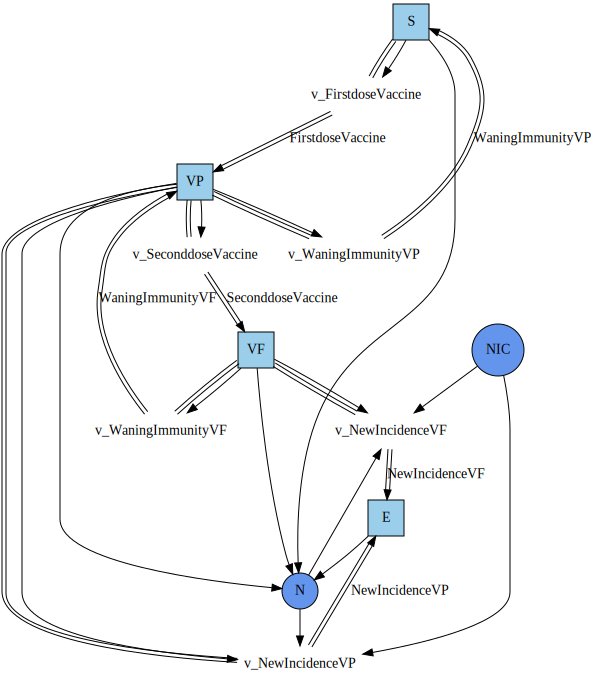

In [8]:
Graph(v;rd="TB")

# Model C:
Model C simulates a disease developmental process for individuals who are persistently asymptomatic. The stocks “IA2” and "IA3" indicate the infected individuals without any symptoms, and they correspond to similiar stage of "IYU" and "IYN" with symptoms respectively.
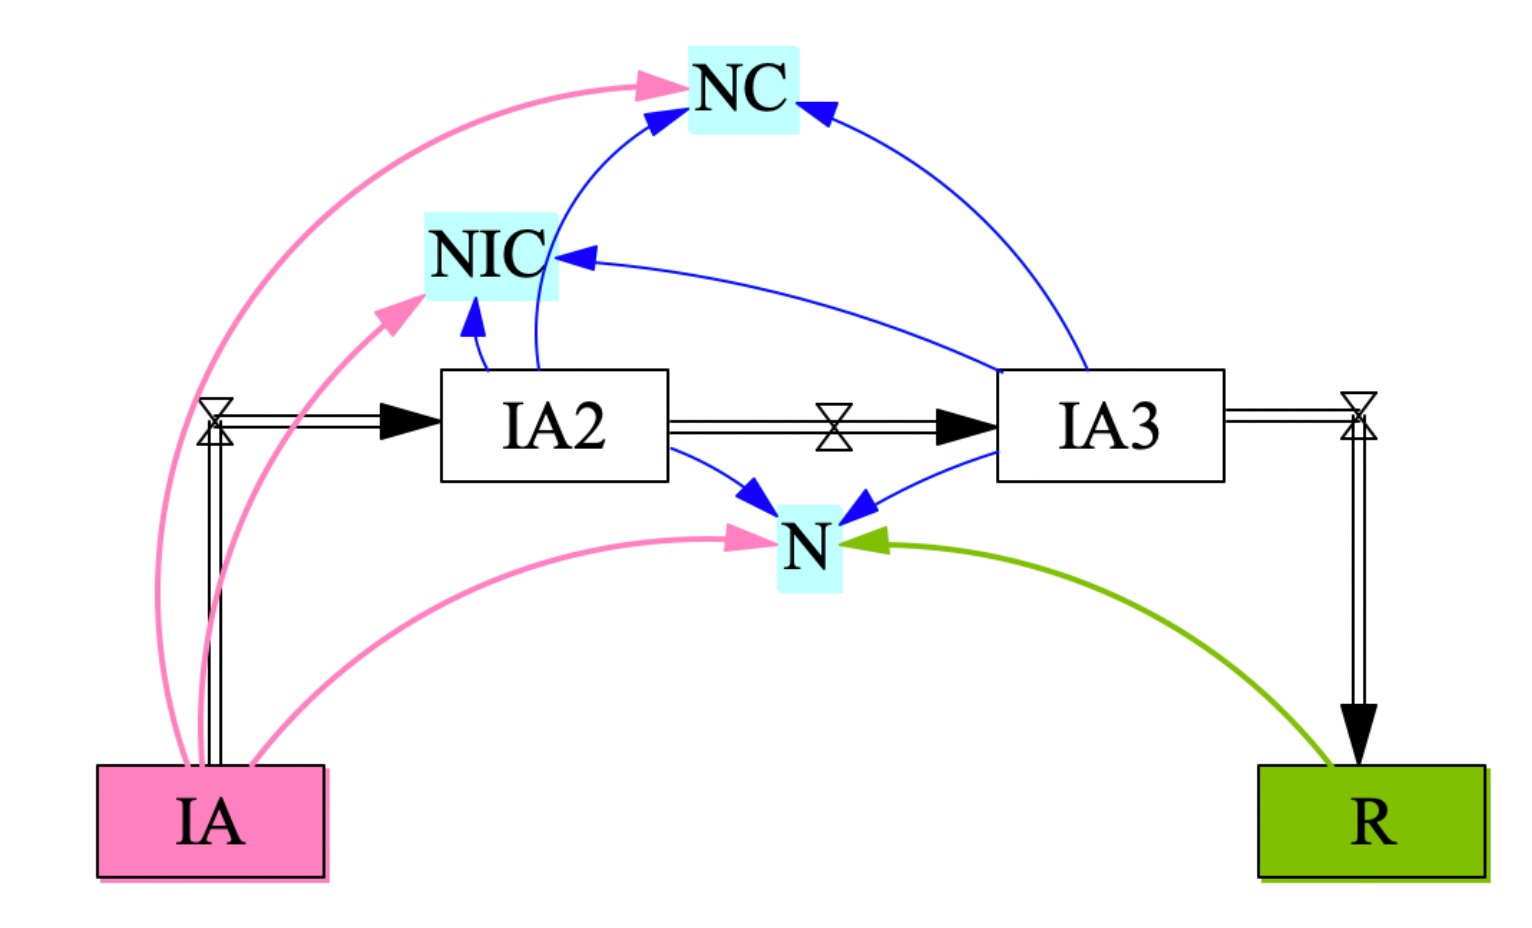

In [9]:
fDevelopmentOfPersistentAsymptomaticity(u,uN,p,t) = u.IA * p.rIncubationIA
fProgressionIA2_IA3(u,uN,p,t) = u.IA2 * p.rDevelopIA2
fNewrecoveryIA3(u,uN,p,t) = u.IA3 * p.rRecoveryIA3

fNewrecoveryIA3 (generic function with 1 method)

In [10]:
ia=StockAndFlow(
    (:IA=>(:F_NONE,:DevelopmentOfPersistentAsymptomaticity,:v_DevelopmentOfPersistentAsymptomaticity,(:N,:NI,:NIC)),
        :IA2=>(:DevelopmentOfPersistentAsymptomaticity,:ProgressionIA2_IA3,:v_ProgressionIA2_IA3,(:N,:NI,:NIC)),
        :IA3=>(:ProgressionIA2_IA3,:NewrecoveryIA3,:v_NewrecoveryIA3,(:N,:NIC,:NI)),
        :R=>(:NewrecoveryIA3,:F_NONE,:V_NONE,:N)),
    (:DevelopmentOfPersistentAsymptomaticity=>:v_DevelopmentOfPersistentAsymptomaticity,:ProgressionIA2_IA3=>:v_ProgressionIA2_IA3,:NewrecoveryIA3=>:v_NewrecoveryIA3),
    (:v_DevelopmentOfPersistentAsymptomaticity=>fDevelopmentOfPersistentAsymptomaticity,:v_ProgressionIA2_IA3=>fProgressionIA2_IA3,:v_NewrecoveryIA3=>fNewrecoveryIA3),
    (:N=>:SVV_NONE,:NIC=>:SVV_NONE,:NI=>:SVV_NONE)
)

StockAndFlow with elements S = 1:4, SV = 1:3, LS = 1:10, F = 1:3, I = 1:3, O = 1:3, V = 1:3, LV = 1:3, LSV = 1:0
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │    IA │
│ 2 │   IA2 │
│ 3 │   IA3 │
│ 4 │     R │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │    NIC │
│  3 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   1 │    3 │
│  3 │   1 │    2 │
│  4 │   2 │    1 │
│  5 │   2 │    3 │
│  6 │   2 │    2 │
│  7 │   3 │    1 │
│  8 │   3 │    2 │
│  9 │   3 │    3 │
│ 10 │   4 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────────────────────────────────┐
│ F │ fv │                                  fname │
├───┼────┼────────────────────────────────────────┤
│ 1 │  1 │ DevelopmentOfPersistentAsymptomaticity │
│ 2 │  2 │                     ProgressionIA2_IA3 │
│ 3 │  3 │                         NewrecoveryIA3 │
└───┴────┴────────────────────────────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
│ 2 │   2 │  3 │
│ 3 │   3 │  4 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  2 │
│ 3 │   3 │  3 │
└───┴─────┴────┘
┌───┬─────────────────────────────────────────┬─────────────────────────────────
│ V │                               funcDynam │                                ⋯
├───┼─────────────────────────────────────────┼─────────────────────────────────
│ 1 │ fDevelopmentOfPersistentAsymptomaticity │ v_DevelopmentOfPersistentAsymp ⋯
│ 2 │                     fProgressionIA2_IA3 │                     v_Progress ⋯
│ 3 │                         fNewrecoveryIA3 │                         v_Newr ⋯
└───┴─────────────────────────────────────────┴─────────────────────────────────
                                                                1 column omitted
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   1 │
│  2 │   2 │   2 │
│  3 │   3 │   3 │
└────┴─────┴─────┘

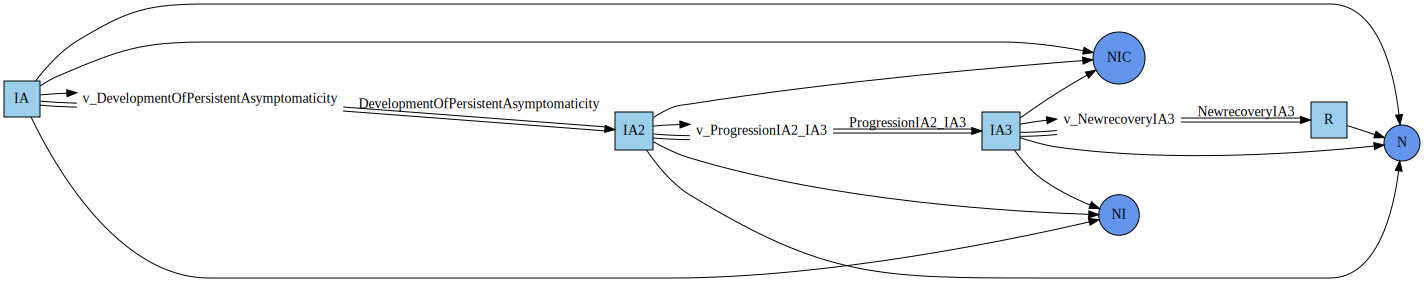

In [11]:
Graph(ia)

# Model D:
Model D simulates the hospitalization process due to COVID-19, where the stocks labelled “HICU” and “HNICU” represent the populations of hospitalized ICU patients and hospitalized non-ICU patients. And the stock "D" represents the hospitalized deaths due to COVID-19 infected patients.
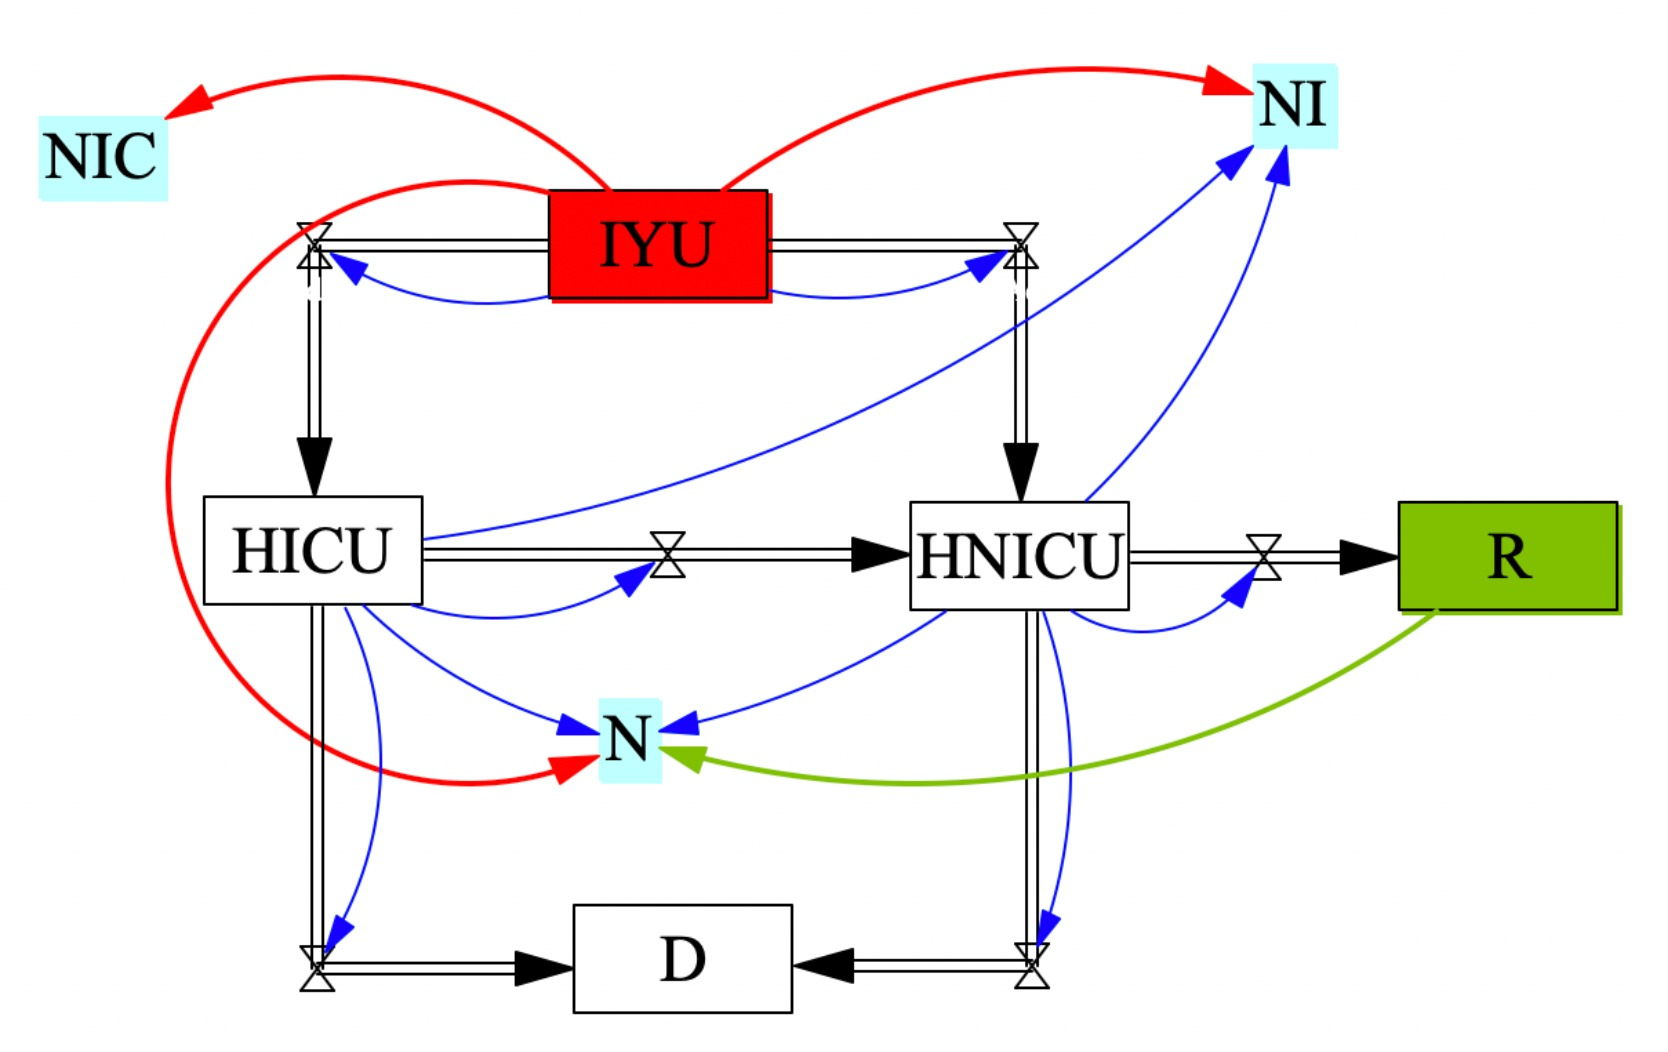

In [12]:
fHICUAdmission(u,uN,p,t) = u.IYU * p.rAdmICU
fHNICUAdmission(u,uN,p,t) = u.IYU * p.rAdmNICU
fOutICU(u,uN,p,t) = u.HICU * p.rOutICU
fRecoveryH(u,uN,p,t)= u.HNICU * p.rrH
fNewDeathsHICU(u,uN,p,t) = u.HICU * p.rDeathICU
fNewDeathsHNICU(u,uN,p,t) = u.HNICU * p.rDeathNICU

fNewDeathsHNICU (generic function with 1 method)

In [13]:
h=StockAndFlow(
    (:IYU=>(:F_NONE,(:HICUAdmission,:HNICUAdmission),(:v_HICUAdmission,:v_HNICUAdmission),(:N,:NI,:NIC)),
        :HICU=>(:HICUAdmission,(:OutICU,:NewDeathsHICU),(:v_OutICU,:v_NewDeathsHICU),(:N,:NI)),
        :HNICU=>((:OutICU,:HNICUAdmission),(:RecoveryH,:NewDeathsHNICU),(:v_RecoveryH,:v_NewDeathsHNICU),(:N,:NI)),
        :R=>(:RecoveryH,:F_NONE,:V_NONE,:N),
        :D=>((:NewDeathsHICU,:NewDeathsHNICU),:F_NONE,:V_NONE,:SV_NONE)),
    (:HICUAdmission=>:v_HICUAdmission,:HNICUAdmission=>:v_HNICUAdmission,:OutICU=>:v_OutICU,:RecoveryH=>:v_RecoveryH,:NewDeathsHICU=>:v_NewDeathsHICU,:NewDeathsHNICU=>:v_NewDeathsHNICU),
    (:v_HICUAdmission=>fHICUAdmission,:v_HNICUAdmission=>fHNICUAdmission,:v_OutICU=>fOutICU,:v_RecoveryH=>fRecoveryH,:v_NewDeathsHICU=>fNewDeathsHICU,:v_NewDeathsHNICU=>fNewDeathsHNICU),
    (:N=>:SVV_NONE,:NIC=>:SVV_NONE,:NI=>:SVV_NONE)
)

StockAndFlow with elements S = 1:5, SV = 1:3, LS = 1:8, F = 1:6, I = 1:6, O = 1:6, V = 1:6, LV = 1:6, LSV = 1:0
┌───┬───────┐
│ S │ sname │
├───┼───────┤
│ 1 │   IYU │
│ 2 │  HICU │
│ 3 │ HNICU │
│ 4 │     R │
│ 5 │     D │
└───┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │    NIC │
│  3 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   1 │    3 │
│  3 │   1 │    2 │
│  4 │   2 │    1 │
│  5 │   2 │    3 │
│  6 │   3 │    1 │
│  7 │   3 │    3 │
│  8 │   4 │    1 │
└────┴─────┴──────┘
┌───┬────┬────────────────┐
│ F │ fv │          fname │
├───┼────┼────────────────┤
│ 1 │  1 │  HICUAdmission │
│ 2 │  2 │ HNICUAdmission │
│ 3 │  3 │         OutICU │
│ 4 │  4 │      RecoveryH │
│ 5 │  5 │  NewDeathsHICU │
│ 6 │  6 │ NewDeathsHNICU │
└───┴────┴────────────────┘
┌───┬─────┬────┐
│ I │ ifn │ is │
├───┼─────┼────┤
│ 1 │   1 │  2 │
│ 2 │   3 │  3 │
│ 3 │   2 │  3 │
│ 4 │   4 │  4 │
│ 5 │   5 │  5 │
│ 6 │   6 │  5 │
└───┴─────┴────┘
┌───┬─────┬────┐
│ O │ ofn │ os │
├───┼─────┼────┤
│ 1 │   1 │  1 │
│ 2 │   2 │  1 │
│ 3 │   3 │  2 │
│ 4 │   5 │  2 │
│ 5 │   4 │  3 │
│ 6 │   6 │  3 │
└───┴─────┴────┘
┌───┬─────────────────┬──────────────────┐
│ V │       funcDynam │            vname │
├───┼─────────────────┼──────────────────┤
│ 1 │  fHICUAdmission │  v_HICUAdmission │
│ 2 │ fHNICUAdmission │ v_HNICUAdmission │
│ 3 │         fOutICU │         v_OutICU │
│ 4 │      fRecoveryH │      v_RecoveryH │
│ 5 │  fNewDeathsHICU │  v_NewDeathsHICU │
│ 6 │ fNewDeathsHNICU │ v_NewDeathsHNICU │
└───┴─────────────────┴──────────────────┘
┌────┬─────┬─────┐
│ LV │ lvs │ lvv │
├────┼─────┼─────┤
│  1 │   1 │   1 │
│  2 │   1 │   2 │
│  3 │   2 │   3 │
│  4 │   2 │   5 │
│  5 │   3 │   4 │
│  6 │   3 │   6 │
└────┴─────┴─────┘

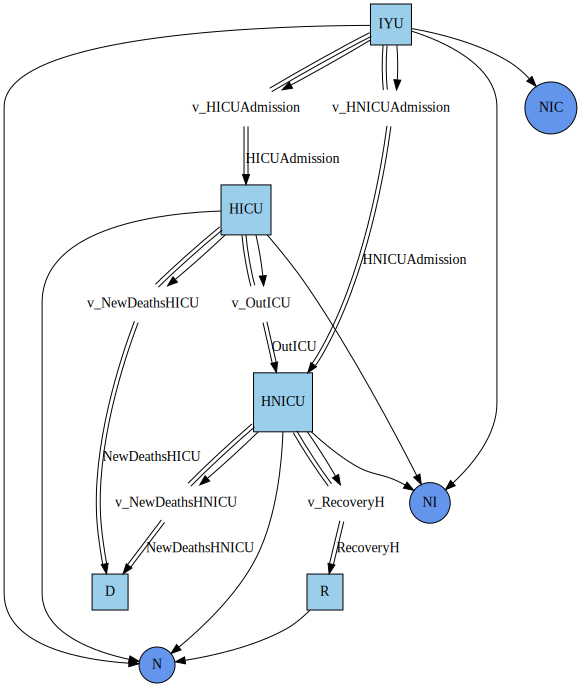

In [14]:
Graph(h;rd="TB")

## Defines the sub-components plans to be composed

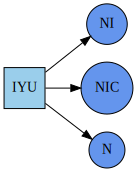

In [15]:
footIYUN=foot(:IYU, (:NI,:NIC,:N), (:IYU=>:NI, :IYU=>:NIC, :IYU=>:N))
Graph(footIYUN;schema="C0")

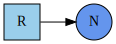

In [16]:
footRN=foot(:R, :N, :R=>:N)
Graph(footRN;schema="C0")

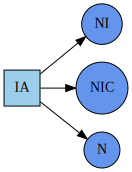

In [17]:
footIAN=foot(:IA, (:NI,:NIC,:N), (:IA=>:NI, :IA=>:NIC, :IA=>:N))
Graph(footIAN;schema="C0")

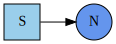

In [18]:
footSN=foot(:S, :N, :S=>:N)
Graph(footSN;schema="C0")

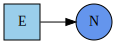

In [19]:
footEN=foot(:E, :N, :E=>:N)
Graph(footEN;schema="C0")

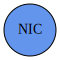

In [20]:
footNIC=foot((),:NIC,())
Graph(footNIC;schema="C0")

## Defines the UWD of composition

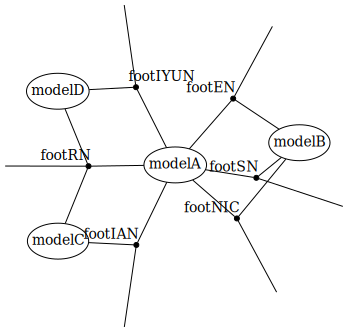

In [21]:
covid = @relation (footSN, footEN, footIAN, footIYUN, footRN, footNIC) begin
    modelA(footSN, footEN, footIAN, footIYUN, footRN, footNIC)
    modelB(footSN, footEN, footNIC)
    modelC(footIAN, footRN)
    modelD(footIYUN, footRN)
end;
display_uwd(covid)

## Composition

In [22]:
open_modelA=Open(seir, footSN, footEN, footIAN, footIYUN, footRN, footNIC)
open_modelB=Open(v,footSN,footEN, footNIC)
open_modelC=Open(ia,footIAN,footRN)
open_modelD=Open(h,footIYUN,footRN)
# Compose those three models according the UWD-algebra
openCOVID19 = oapply(covid, [open_modelA, open_modelB, open_modelC, open_modelD])
# composed model
COVID19=apex(openCOVID19)

StockAndFlow with elements S = 1:13, SV = 1:3, LS = 1:24, F = 1:21, I = 1:21, O = 1:21, V = 1:21, LV = 1:21, LSV = 1:6
┌────┬───────┐
│  S │ sname │
├────┼───────┤
│  1 │     S │
│  2 │     E │
│  3 │    IA │
│  4 │   IYU │
│  5 │   IYN │
│  6 │     R │
│  7 │    VP │
│  8 │    VF │
│  9 │   IA2 │
│ 10 │   IA3 │
│ 11 │  HICU │
│ 12 │ HNICU │
│ 13 │     D │
└────┴───────┘
┌────┬────────┐
│ SV │ svname │
├────┼────────┤
│  1 │      N │
│  2 │    NIC │
│  3 │     NI │
└────┴────────┘
┌────┬─────┬──────┐
│ LS │ lss │ lssv │
├────┼─────┼──────┤
│  1 │   1 │    1 │
│  2 │   2 │    1 │
│  3 │   3 │    1 │
│  4 │   3 │    2 │
│  5 │   3 │    3 │
│  6 │   4 │    1 │
│  7 │   4 │    2 │
│  8 │   4 │    3 │
│  9 │   5 │    1 │
│ 10 │   5 │    2 │
│ 11 │   5 │    3 │
│ 12 │   6 │    1 │
│ 13 │   7 │    1 │
│ 14 │   8 │    1 │
│ 15 │   9 │    1 │
│ 16 │   9 │    3 │
│ 17 │   9 │    2 │
│ 18 │  10 │    1 │
│ 19 │  10 │    2 │
│ 20 │  10 │    3 │
│ 21 │  11 │    1 │
│ 22 │  11 │    3 │
│ 23 │  12 │    1 │
│ 24 │  12 │    3 │
└────┴─────┴──────┘
┌────┬────┬────────────────────────────────────────┐
│  F │ fv │                                  fname │
├────┼────┼────────────────────────────────────────┤
│  1 │  1 │                           NewIncidence │
│  2 │  2 │                          NewInfectious │
│  3 │  3 │                    BecomingSymptomatic │
│  4 │  4 │   SymptomicsNotDevelopingComplications │
│  5 │  5 │                            NewRecovery │
│  6 │  6 │                        WaningImmunityR │
│  7 │  7 │                       WaningImmunityVP │
│  8 │  8 │                       WaningImmunityVF │
│  9 │  9 │                       FirstdoseVaccine │
│ 10 │ 10 │                      SeconddoseVaccine │
│ 11 │ 11 │                         NewIncidenceVP │
│ 12 │ 12 │                         NewIncidenceVF │
│ 13 │ 13 │ DevelopmentOfPersistentAsymptomaticity │
│ 14 │ 14 │                     ProgressionIA2_IA3 │
│ 15 │ 15 │                         NewrecoveryIA3 │
│ 16 │ 16 │                          HICUAdmission │
│ 17 │ 17 │                         HNICUAdmission │
│ 18 │ 18 │                                 OutICU │
│ 19 │ 19 │                              RecoveryH │
│ 20 │ 20 │                          NewDeathsHICU │
│ 21 │ 21 │                         NewDeathsHNICU │
└────┴────┴────────────────────────────────────────┘
┌────┬─────┬────┐
│  I │ ifn │ is │
├────┼─────┼────┤
│  1 │   6 │  1 │
│  2 │   1 │  2 │
│  3 │   2 │  3 │
│  4 │   3 │  4 │
│  5 │   4 │  5 │
│  6 │   5 │  6 │
│  7 │   7 │  1 │
│  8 │  11 │  2 │
│  9 │  12 │  2 │
│ 10 │   9 │  7 │
│ 11 │   8 │  7 │
│ 12 │  10 │  8 │
│ 13 │  13 │  9 │
│ 14 │  14 │ 10 │
│ 15 │  15 │  6 │
│ 16 │  16 │ 11 │
│ 17 │  18 │ 12 │
│ 18 │  17 │ 12 │
│ 19 │  19 │  6 │
│ 20 │  20 │ 13 │
│ 21 │  21 │ 13 │
└────┴─────┴────┘
┌────┬─────┬────┐
│  O │ ofn │ os │
├────┼─────┼────┤
│  1 │   1 │  1 │
│  2 │   2 │  2 │
│  3 │   3 │  3 │
│  4 │   4 │  4 │
│  5 │   5 │  5 │
│  6 │   6 │  6 │
│  7 │   9 │  1 │
│  8 │  10 │  7 │
│  9 │   7 │  7 │
│ 10 │  11 │  7 │
│ 11 │   8 │  8 │
│ 12 │  12 │  8 │
│ 13 │  13 │  3 │
│ 14 │  14 │  9 │
│ 15 │  15 │ 10 │
│ 16 │  16 │  4 │
│ 17 │  17 │  4 │
│ 18 │  18 │ 11 │
│ 19 │  20 │ 11 │
│ 20 │  19 │ 12 │
│ 21 │  21 │ 12 │
└────┴─────┴────┘
┌────┬─────────────────────────────────────────┬────────────────────────────────
│  V │                               funcDynam │                               ⋯
├────┼─────────────────────────────────────────┼────────────────────────────────
│  1 │                           fNewIncidence │                           v_N ⋯
│  2 │                          fNewInfectious │                          v_Ne ⋯
│  3 │                    fBecomingSymptomatic │                    v_Becoming ⋯
│  4 │   fSymptomicsNotDevelopingComplications │   v_SymptomicsNotDevelopingCo ⋯
│  5 │                            fNewRecovery │                            v_ ⋯
│  6 │                        fWaningImmunityR │                        v_Wani ⋯


Composed model:
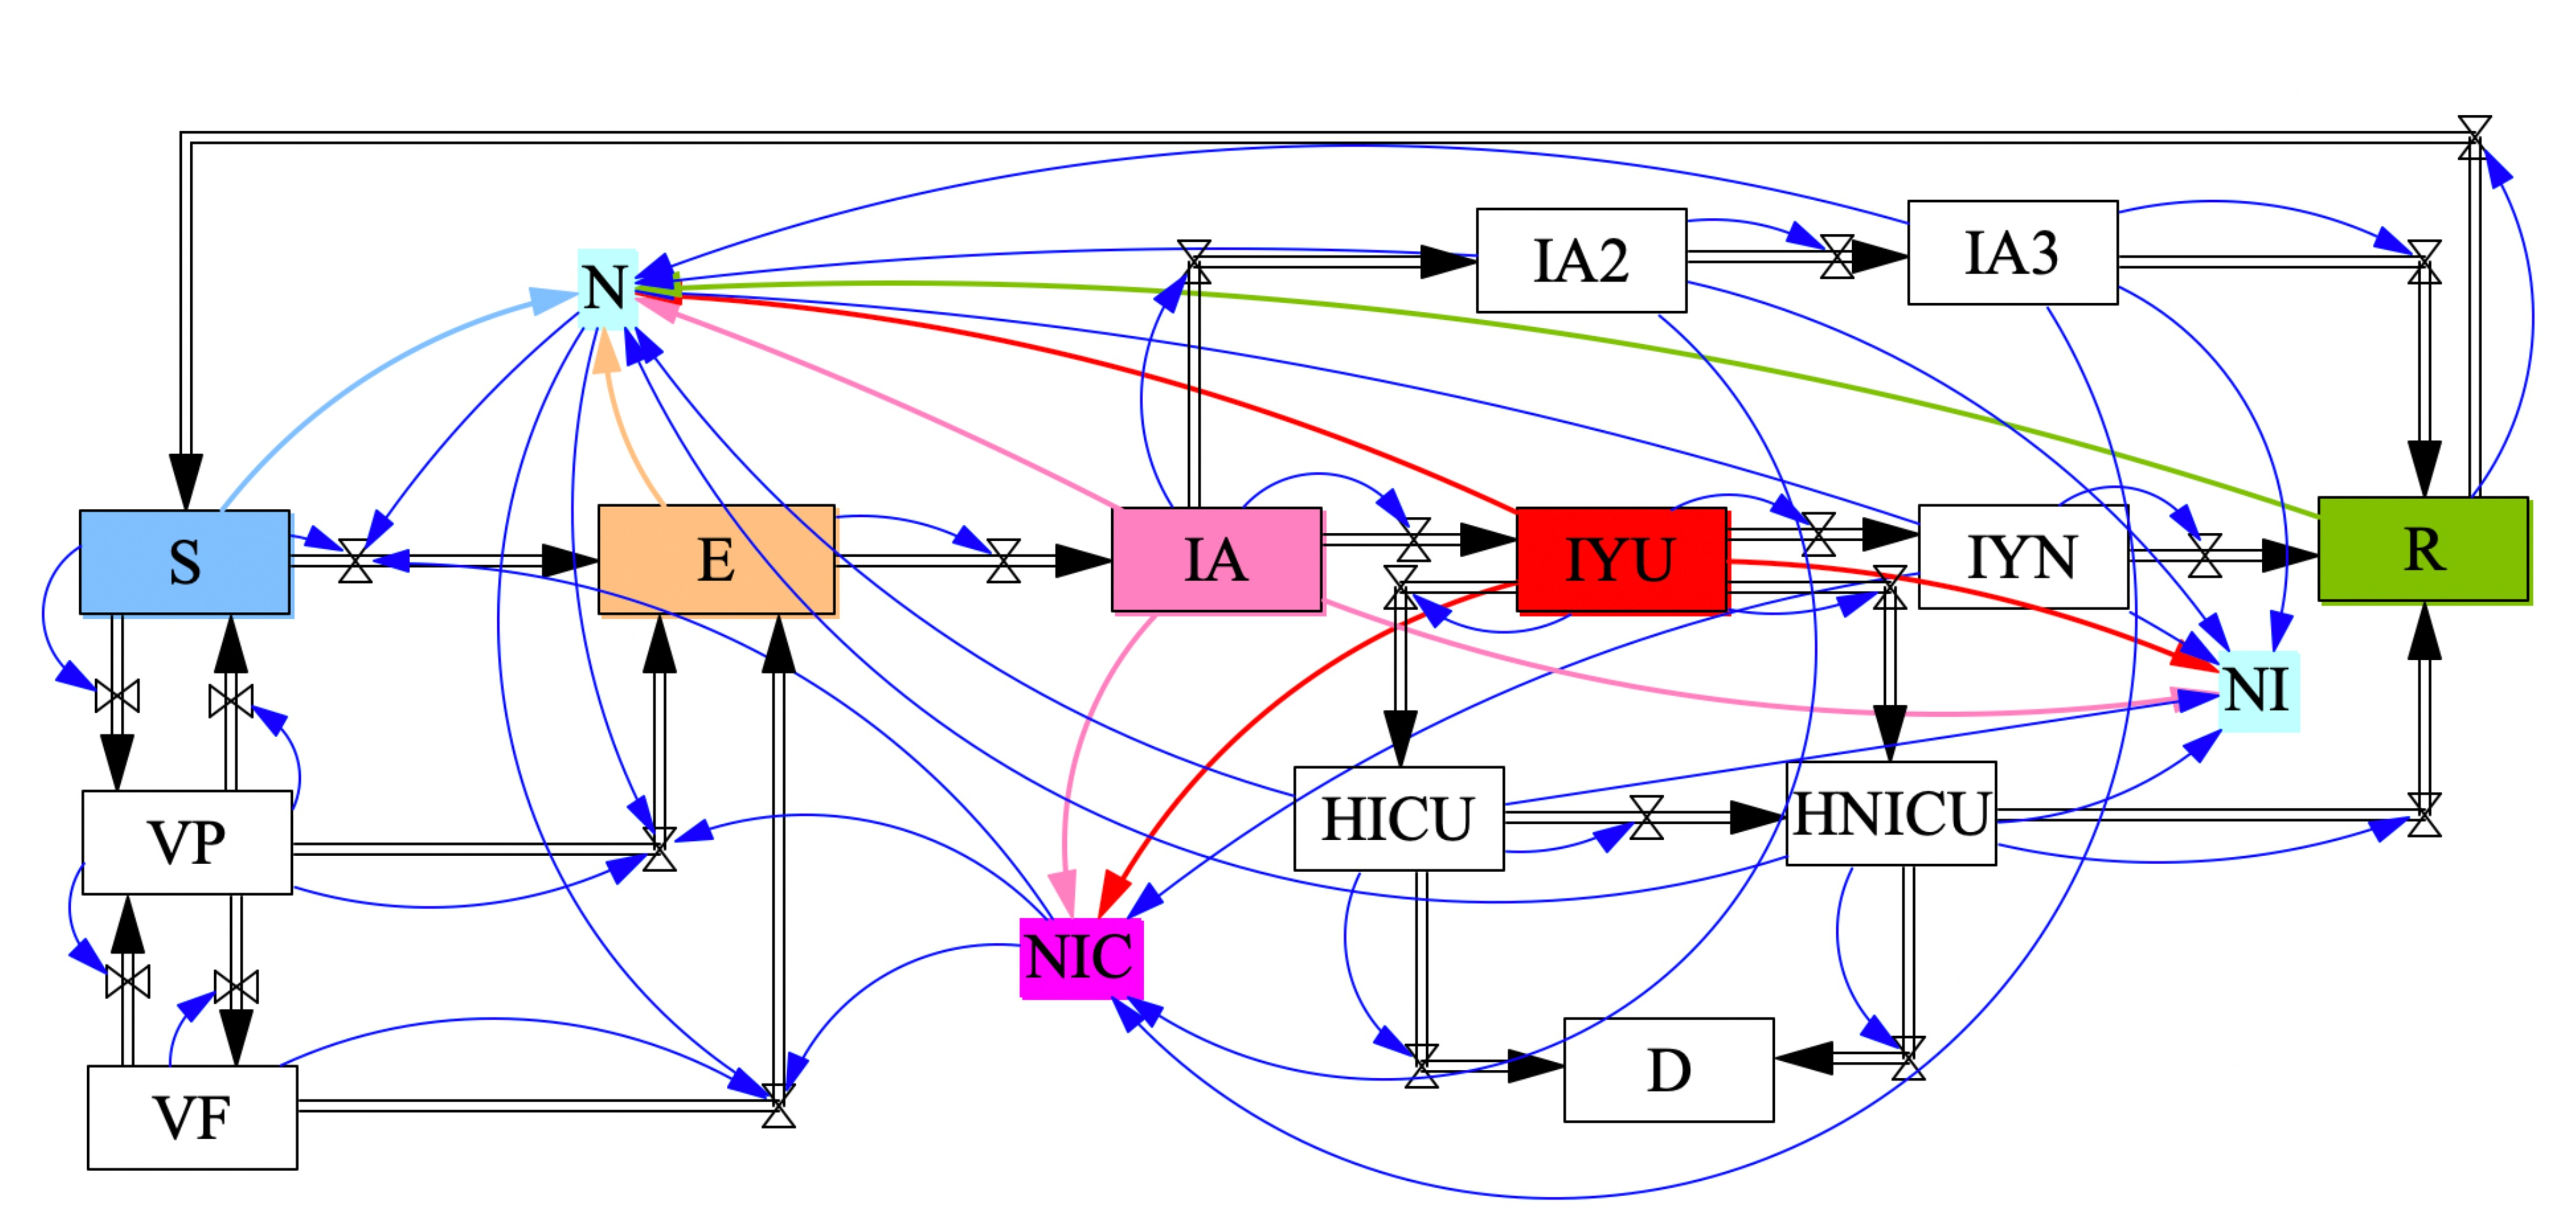

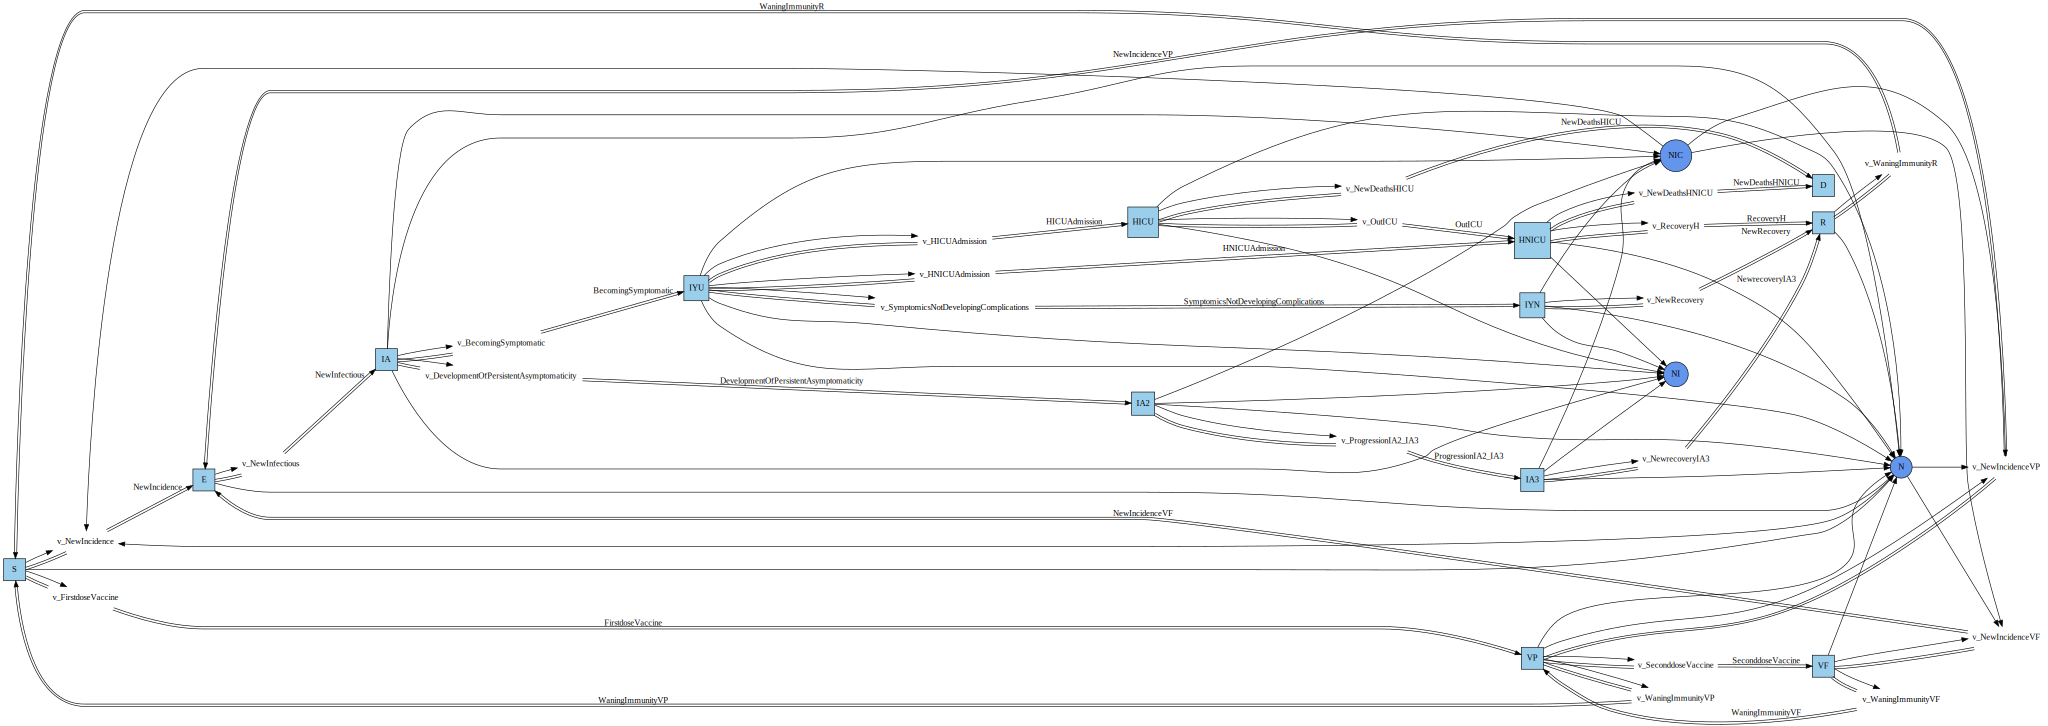

In [23]:
Graph(COVID19)

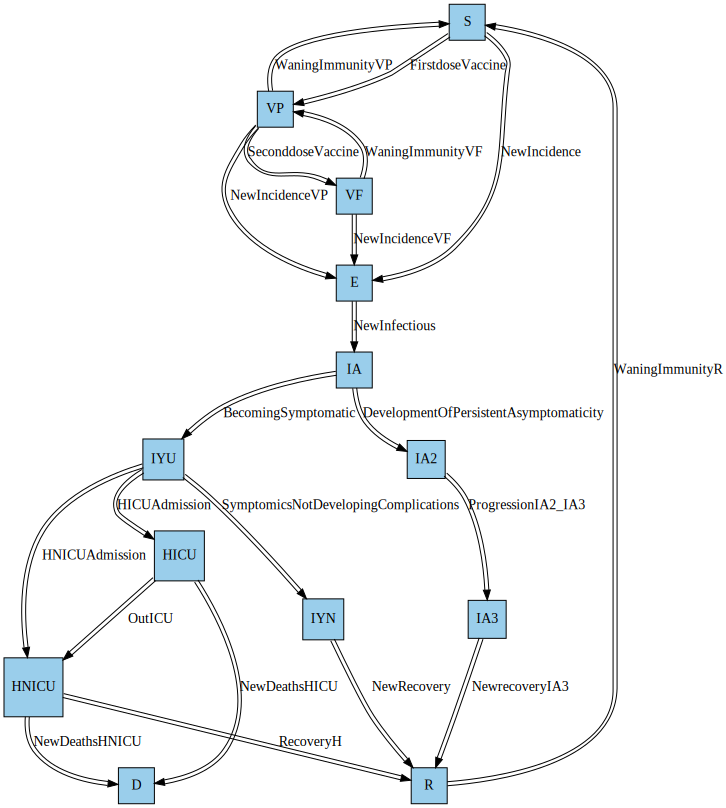

In [24]:
Graph(COVID19; type="SF", rd="TB")

# Define parameters and initial values

In [25]:
# define constant parameters
p_COVID19_raw = LVector(
    β=0.8, tLatent=2.9, tIncubation=2.72, tDevelop=6.0, tRecovery=3.5,tw=2*365.0,
    fH=0.002, fICU=0.23, tICU=6.0, tH = 12.0, tOutICU=6.0, fractionIA=0.4
)


p_COVID19 = LVector(
    β=p_COVID19_raw.β, rLatent=1.0/p_COVID19_raw.tLatent, rIncubation=(1.0-p_COVID19_raw.fractionIA)/p_COVID19_raw.tIncubation,
    rDevelop=(1.0-p_COVID19_raw.fH)/p_COVID19_raw.tDevelop, rRecovery=1.0/p_COVID19_raw.tRecovery, rw=1.0/p_COVID19_raw.tw,
    rv=0.01, eP=0.6, eF=0.85, rIncubationIA=p_COVID19_raw.fractionIA/p_COVID19_raw.tIncubation, 
    rDevelopIA2=1.0/p_COVID19_raw.tDevelop, rRecoveryIA3=1.0/p_COVID19_raw.tRecovery,
    rAdmICU=p_COVID19_raw.fH*p_COVID19_raw.fICU/p_COVID19_raw.tDevelop,
    rAdmNICU=p_COVID19_raw.fH*(1.0-p_COVID19_raw.fICU)/p_COVID19_raw.tDevelop,
    rrH=1.0/p_COVID19_raw.tH, rOutICU=1.0/p_COVID19_raw.tOutICU,rDeathICU=0.085, rDeathNICU=0.018
)
# define initial values for stocks
u0_COVID19 = LVector(
    S=38010000.0, E=0.0, IYU=10.0, IA=0.0, R=0.0, HICU=0.0, HNICU=0.0, VP=0.0, VF=0.0,
    D=0.0, IA2=0.0, IA3=0.0, IYN=0.0
)

13-element LArray{Float64, 1, Vector{Float64}, (:S, :E, :IYU, :IA, :R, :HICU, :HNICU, :VP, :VF, :D, :IA2, :IA3, :IYN)}:
     :S => 3.801e7
     :E => 0.0
   :IYU => 10.0
    :IA => 0.0
     :R => 0.0
  :HICU => 0.0
 :HNICU => 0.0
    :VP => 0.0
    :VF => 0.0
     :D => 0.0
   :IA2 => 0.0
   :IA3 => 0.0
   :IYN => 0.0

# Solve the ODEs

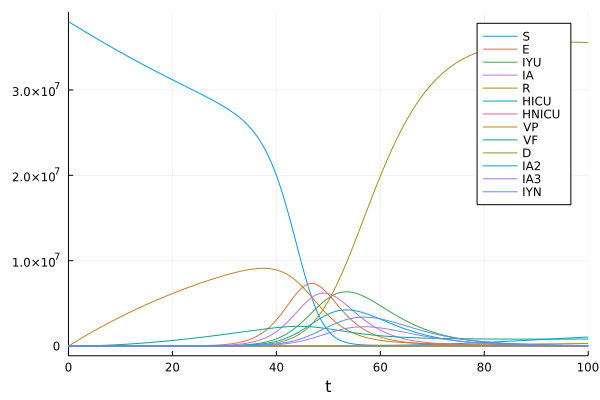

In [26]:
# results are tested the same as the Anylogic model
prob_COVID19 = ODEProblem(vectorfield(COVID19),u0_COVID19,(0.0,100.0),p_COVID19);
sol_COVID19 = solve(prob_COVID19,Tsit5(),abstol=1e-8);
plot(sol_COVID19)